In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
import cmocean.cm
import matplotlib.colors
import skimage.color
import datetime
import geojson

%matplotlib inline

C:\Anaconda\envs\py36\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
url = 'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/hydrodynamics/adcp/adcp-f.nc'

In [3]:
ds = netCDF4.Dataset(url)

ds.variables.keys()

odict_keys(['x', 'y', 'time', 'Z', 'east_velocity', 'north_velocity', 'velocity', 'velocity_direction', 'error_velocity', 'crs', 'lat', 'lon', 'number_of_depths', 'waterdepth'])

In [4]:
point = geojson.Point(coordinates=[
    float(np.squeeze(ds.variables['lon'][:])), 
    float(np.squeeze(ds.variables['lat'][:]))
])
feature = geojson.Feature(id='adcp-f', geometry=point)
feature

{"geometry": {"coordinates": [4.217663764953613, 52.080467224121094], "type": "Point"}, "id": "adcp-f", "properties": {}, "type": "Feature"}

In [5]:
# time
times = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)

# veclocities
U = np.squeeze(np.ma.masked_equal(ds.variables['north_velocity'][:], 9.96920997e+36).astype('double'))
V = np.squeeze(np.ma.masked_equal(ds.variables['east_velocity'][:], 9.96920997e+36).astype('double'))

# waterdepth
ssh = np.squeeze(np.ma.masked_equal(ds.variables['waterdepth'][:], 9.96920997e+36).astype('double'))

# convert to angle, magnitude
angle = np.arctan2(V, U)
mag = np.ma.sqrt(U**2 + V**2)

# height of measurement
Z = np.squeeze(np.ma.masked_equal(ds.variables['Z'][:], 9.96920997e+36).astype('double'))

# Create Time matrix
T = np.repeat(ds.variables['time'][:][:, np.newaxis], len(ds.dimensions['bins']), axis=1)

In [6]:
# interpolate accross a consistent Z grid
z_new = np.linspace(Z.min(), Z.max(), num=100)
interps = []
N = mag.shape[0]
for i in range(N):
    values = np.c_[
        mag[i].filled(np.nan), 
        U[i].filled(np.nan), 
        V[i].filled(np.nan)
    ]
    f = scipy.interpolate.interp1d(
        Z[i], 
        values.T, 
        bounds_error=False
    )
    interps.append(
        f(z_new).T
    )

In [7]:
# lookup date differences
diffs = np.array([x.total_seconds() for x in np.diff(times)])
# compute split points (more than 20min)
splits = np.where(diffs > 1200)[0]
times_splitted = np.split(times, splits)
mag_interp = np.ma.masked_invalid(interps)[:, :, 0].T
mag_interp_anomaly = mag_interp - mag_interp.mean(axis=0)
U_interp = np.ma.masked_invalid(interps)[:, :, 1].T
V_interp = np.ma.masked_invalid(interps)[:, :, 2].T


In [8]:
uvmax = np.ma.abs([U_interp.min(), U_interp.max(), V_interp.min(), V_interp.max()]).max()
mag_anomaly_max = np.ma.abs(mag_interp_anomaly).max()

In [40]:
print(np.shape(ssh))


(196782,)


In [43]:
import json
N = 1000
jsonlist = dict({'times': list(matplotlib.dates.date2num(times[:N])), 'waterdepth': list(ssh.data[:N])})
data = dict({})
for time in range(len(times[:N])):
    data[time] = list(mag_interp_anomaly.data[:, time])
    
jsonlist['data'] = data
# print(jsonlist)
with open('adcp_data_1000.json', 'w') as f:
    json.dump(jsonlist, f)

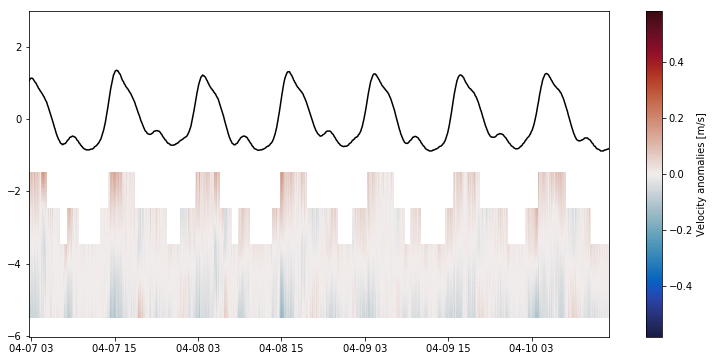

In [9]:
fig, ax = plt.subplots(figsize=(13, 6))
N_ssh = matplotlib.colors.Normalize(ssh.min(), ssh.max())
ax.plot([time for time in times], ssh, 'k-')
aspect = ax.get_aspect()
# or use    mag_interp     vmax=mag_interp.max(),    cmap=cmocean.cm.speed
ax.set_xlim(
    matplotlib.dates.date2num(times[1000]), 
    matplotlib.dates.date2num(times[2000])
)
ax.set_ylim(z_new[0], 3)

pc = ax.pcolormesh(
    matplotlib.dates.date2num(times[:43900]), 
    z_new, 
    mag_interp_anomaly[:, :43900][:-1, :-1],
    vmin=-mag_anomaly_max*0.8,
    vmax=mag_anomaly_max*0.8,
    cmap=cmocean.cm.balance
)
plt.colorbar(pc, ax=ax, label='Velocity anomalies [m/s]')
ax.set_aspect(aspect)


In [10]:
begin, end = times[0], times[-1]

In [13]:
months = pd.date_range(datetime.datetime(begin.year, begin.month, 1), end, freq='1MS' ) 

In [14]:
for month in months:
    s = list(map(lambda x: (x.year, x.month) == (month.year, month.month), times))
    if not any(s):
         continue
    plt.imsave(
        'mag_%06d.png' % (month.year * 100 + month.month, ), 
        mag_interp[:, s], 
        cmap=cmocean.cm.speed, 
        vmin=0,
        vmax=1.5,
        origin='lower'
    )
    plt.imsave(
        'mag_anomaly_%06d.png' % (month.year * 100 + month.month, ), 
        mag_interp_anomaly[:, s], 
        cmap=cmocean.cm.balance, 
        vmin=-0.8*mag_anomaly_max, 
        vmax=0.8*mag_anomaly_max, 
        origin='lower'
    )
    plt.imsave(
        'uv_%06d.png' % (month.year * 100 + month.month, ), 
        np.ma.arctan2(V_interp[:, s], U_interp[:, s]), 
        cmap=cmocean.cm.phase, 
        vmin=-np.pi, 
        vmax=np.pi, 
        origin='lower'
    )
    